<a href="https://colab.research.google.com/github/FreeOnel/Deep-RL-Pacman/blob/main/03_04_of_RL_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
# Run this code block to install relevant modules
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -U colabgymrender
!pip install -U wandb

Requirement already up-to-date: colabgymrender in /usr/local/lib/python3.7/dist-packages (1.0.8)
     |████████████████████████████████| 2.1MB 20.9MB/s 
     |████████████████████████████████| 133kB 52.3MB/s 
     |████████████████████████████████| 163kB 49.4MB/s 
     |████████████████████████████████| 102kB 11.1MB/s 
     |████████████████████████████████| 71kB 9.4MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=4729421a74b7a72b738be4256cb751d573452626e2c5043437156d3df5ea5ed0
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=d9866ae18ba942f253e8648a423822547e2104b87c735b52c26dfc57258d90bd
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built pathtools subprocess32


In [ ]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import pickle
import wandb

# Initialise environment and run test recording
import gym
from colabgymrender.recorder import Recorder

env = gym.make("MsPacman-v0")

def sample(env):
  directory = './video'
  env = Recorder(env, directory)

  observation = env.reset()
  terminal = False
  while not terminal:
    action = env.action_space.sample()
    observation, reward, terminal, info = env.step(action)
  
  return env

#sample(env).play()

In [ ]:
from PIL import Image

# Image pre processing, following the steps outlined by deepmind, 2013
def preprocess(observation):

  # Create Image object from numpy array
  image = Image.fromarray(observation)

  # Convert from RGB to grayscale
  image = image.convert('L')

  # Downsize from 210x160 to 110x84
  image = image.resize((84,110))

  # Crop to playing area only (84x84)
  image = image.crop((0,0,84,84))

  return np.array(image)

#preprocess(observation)
#Image.fromarray(observation)



In [ ]:
color = np.array([210, 164, 74]).mean()

#prepro (210, 160, 3) uint8 frame into 7040 (88x80) 1D float vector 

def preprocess_observation(obs):

    # Crop and resize the image
    img = obs[1:176:2, ::2]

    # Convert the image to greyscale
    img = img.mean(axis=2)

    # Improve image contrast
    img[img==color] = 0

    # Next we normalize the image from -1 to +1
    img = (img - 128) / 128 - 1

    return img.reshape(88,80,1)

In [ ]:
# Define Q-Network 

n_outputs = env.action_space.n

def q_network(X, name_scope):

  initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=2.0)

  with tf.compat.v1.variable_scope(name_scope, reuse=tf.compat.v1.AUTO_REUSE) as scope:

    layer_1 = tf.compat.v1.layers.conv2d(X, 32, kernel_size=(8,8), strides=(4,4), padding='SAME', kernel_initializer=initializer, activation=tf.nn.relu)

    layer_2 = tf.compat.v1.layers.conv2d(layer_1, 64, kernel_size=(4,4), strides=(2,2), padding='SAME', kernel_initializer=initializer, activation=tf.nn.relu)

    layer_3 = tf.compat.v1.layers.conv2d(layer_2, 64, kernel_size=(3,3), strides=(1,1), padding='SAME', kernel_initializer=initializer, activation=tf.nn.relu)

    flat = tf.compat.v1.layers.Flatten()(layer_3)

    fc = tf.compat.v1.layers.Dense(128, kernel_initializer=initializer, activation='relu')(flat)

    output = tf.compat.v1.layers.Dense(n_outputs, activation=None, kernel_initializer=initializer)(fc)

    vars = {v.name[len(scope.name):]: v for v in tf.compat.v1.get_collection(key=tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)}
  
  return vars, output




In [ ]:
# Copied parameters from article (change later?)
num_episodes = 800
batch_size = 48
input_shape = (None, 88, 80, 1)
#Recall shape is img.reshape(88,80,1)
learning_rate = 0.001
X_shape = (None, 88, 80, 1)
discount_factor = 0.97
global_step = 0
copy_steps = 100
steps_train = 4
start_steps = 2000

In [ ]:
logdir = 'logs'
tf.compat.v1.reset_default_graph()

# Now we define the placeholder for our input i.e game state
tf.compat.v1.disable_eager_execution()
X = tf.compat.v1.placeholder(tf.float32, shape=X_shape)

# we define a boolean called in_training_model to toggle the training
in_training_mode = tf.compat.v1.placeholder(tf.bool)

In [ ]:
mainQ, mainQ_outputs = q_network(X,'mainQ')

In [ ]:
# Epsilon Greedy Policy

epsilon = 0.5
eps_min = 0.05
eps_max = 1.0
eps_decay_steps = 500000

def epsilon_greedy(action, step):
  p = np.random.random(1).squeeze() #1D entries returned using squeeze
  epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps) #Decaying policy with more steps
  if np.random.rand() < epsilon:
    return np.random.randint(n_outputs)
  else:
    return action

In [ ]:
# Buffer

from collections import deque, Counter

buffer_len = 20000
#Buffer is made from a deque — double ended queue
exp_buffer = deque(maxlen=buffer_len)
def sample_memories(batch_size):
  perm_batch = np.random.permutation(len(exp_buffer))[:batch_size]
  mem = np.array(exp_buffer)[perm_batch]
  return mem[:,0], mem[:,1], mem[:,2], mem[:,3], mem[:,4]

In [ ]:
# similarly we build our target Q network, for policy evaluation
targetQ, targetQ_outputs = q_network(X, 'targetQ')

X_action = tf.compat.v1.placeholder(tf.int32, shape=(None,))
Q_action = tf.reduce_sum(input_tensor=targetQ_outputs * tf.one_hot(X_action, n_outputs), axis=-1, keepdims=True)

# Copies target weights to main
copy_op = [tf.compat.v1.assign(main_name, targetQ[var_name]) for var_name, main_name in mainQ.items()]
copy_target_to_main = tf.group(*copy_op)

In [ ]:
# Loss Function

# define a placeholder for our output i.e action
y = tf.compat.v1.placeholder(tf.float32, shape=(None,1))
# now we calculate the loss which is the difference between actual value and predicted value
loss = tf.reduce_mean(input_tensor=tf.square(y - Q_action))
# we use adam optimizer for minimizing the loss
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)
init = tf.compat.v1.global_variables_initializer()
loss_summary = tf.compat.v1.summary.scalar('LOSS', loss)
merge_summary = tf.compat.v1.summary.merge_all()
file_writer = tf.compat.v1.summary.FileWriter(logdir, tf.compat.v1.get_default_graph())

In [ ]:
with tf.compat.v1.Session() as sess:
    init.run()
    wb = True
    if wb:
      wandb.init(project='vanillapacman', entity='pacman_dqn')
    
    # for each episode
    history = []
    for i in range(num_episodes):
        done = False
        obs = env.reset()
        epoch = 0
        episodic_reward = 0
        actions_counter = Counter() 
        episodic_loss = []

        # while the state is not the terminal state
        while not done:

           #env.render()
        
            # get the preprocessed game screen
            obs = preprocess_observation(obs)

            # feed the game screen and get the Q values for each action,  FEED THE NETWORK BY CALLING THE OUTPUT LAYER
            
            actions = mainQ_outputs.eval(feed_dict={X:[obs], in_training_mode:False})

            # get the action
            action = np.argmax(actions, axis=-1)
            actions_counter[str(action)] += 1 

            # select the action using epsilon greedy policy
            action = epsilon_greedy(action, global_step)
            
            # now perform the action and move to the next state, next_obs, receive reward
            next_obs, reward, done, _ = env.step(action)

            # Store this transistion as an experience in the replay buffer! Quite important
            exp_buffer.append([obs, action, preprocess_observation(next_obs), reward, done])
            
            # After certain steps, we train our Q network with samples from the experience replay buffer
            if global_step % steps_train == 0 and global_step > start_steps:
                
                # sample experience, mem[:,0], mem[:,1], mem[:,2], mem[:,3], mem[:,4]
                o_obs, o_act, o_next_obs, o_rew, o_done = sample_memories(batch_size)

                # states
                o_obs = [x for x in o_obs]

                # next states
                o_next_obs = [x for x in o_next_obs]

                # next actions
                next_act = mainQ_outputs.eval(feed_dict={X:o_next_obs, in_training_mode:False})


                # discounted reward: these are our Y-values
                y_batch = o_rew + discount_factor * np.max(next_act, axis=-1) * (1-o_done) 

                # merge all summaries and write to the file
                mrg_summary = merge_summary.eval(feed_dict={X:o_obs, y:np.expand_dims(y_batch, axis=-1), X_action:o_act, in_training_mode:False})
                file_writer.add_summary(mrg_summary, global_step)

                # To calculate the loss, we run the previously defined functions mentioned while feeding inputs
                train_loss, _ = sess.run([loss, training_op], feed_dict={X:o_obs, y:np.expand_dims(y_batch, axis=-1), X_action:o_act, in_training_mode:True})
                episodic_loss.append(train_loss)
              
            
            # after some interval we copy our main Q network weights to target Q network
            if (global_step+1) % copy_steps == 0 and global_step > start_steps:
                copy_target_to_main.run()
                
            obs = next_obs
            epoch += 1
            global_step += 1
            episodic_reward += reward
        
        history.append(episodic_reward)
        print('Epochs per episode:', epoch, 'Episode Reward:', episodic_reward,"Episode number:", len(history))
        if wb:
          wandb.log({'epochs_per_episode:': epoch, 'episode': len(history), 'episodic_reward': episodic_reward})
        # obj0, obj1, obj2 are created here...

        # Saving the objects:
        #with open('/drive/MyDrive/RL_project/history.pkl', 'w') as f:  # Python 3: open(..., 'wb')
        #    pickle.dump(history, f)

epochs_per_episode:,690
episode,1
episodic_reward,180.0
_runtime,5
_timestamp,1617444759
_step,0


epochs_per_episode:,▁
episode,▁
episodic_reward,▁
_runtime,▁
_timestamp,▁
_step,▁


Epochs per episode: 740 Episode Reward: 190.0 Episode number: 1
Epochs per episode: 574 Episode Reward: 230.0 Episode number: 2
Epochs per episode: 788 Episode Reward: 340.0 Episode number: 3
Epochs per episode: 633 Episode Reward: 230.0 Episode number: 4
Epochs per episode: 744 Episode Reward: 230.0 Episode number: 5
Epochs per episode: 627 Episode Reward: 160.0 Episode number: 6
Epochs per episode: 636 Episode Reward: 160.0 Episode number: 7
Epochs per episode: 701 Episode Reward: 250.0 Episode number: 8
Epochs per episode: 555 Episode Reward: 220.0 Episode number: 9
Epochs per episode: 673 Episode Reward: 240.0 Episode number: 10
Epochs per episode: 584 Episode Reward: 200.0 Episode number: 11
Epochs per episode: 621 Episode Reward: 230.0 Episode number: 12
Epochs per episode: 610 Episode Reward: 210.0 Episode number: 13
Epochs per episode: 646 Episode Reward: 160.0 Episode number: 14
Epochs per episode: 433 Episode Reward: 120.0 Episode number: 15
Epochs per episode: 560 Episode Re

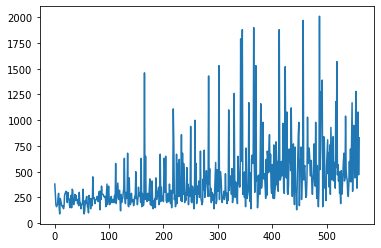

In [ ]:
plt.plot(history)
plt.show()

History saved to './drive/MyDrive/history.pkl'


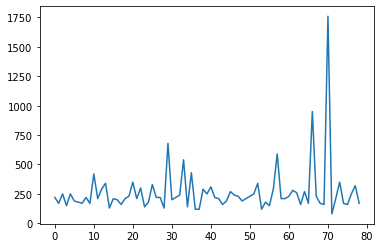

In [ ]:
# Saving the objects:
data_to_save = ['history', 'mainQ']
data_location = './drive/MyDrive/data.pkl'
def save_variables():
  try:
    with open(data_location, 'wb') as f:  # Python 3: open(..., 'wb')
      for var in data_to_save:
        eval(f"pickle.dump({var}, f)")
    print(f"History saved to {data_location}")
  except FileNotFoundError:
    print("Mount google drive if you wish to save the history")

def load_variables():
  # Getting back the objects:
  with open(data_location, 'rb') as f:  # Python 3: open(..., 'rb')
      for var in data_to_save:
        exec(f"{var} = pickle.load(f)")
  return history



In [ ]:
# Copy of above, wihh episode variable nearer
num_episodes = 10

with tf.compat.v1.Session() as sess:
    init.run()
    
    # for each episode
    history = []
    for i in range(num_episodes):
        done = False
        obs = env.reset()
        epoch = 0
        episodic_reward = 0
        actions_counter = Counter() 
        episodic_loss = []

        # while the state is not the terminal state
        while not done:

           #env.render()
        
            # get the preprocessed game screen
            obs = preprocess_observation(obs)

            # feed the game screen and get the Q values for each action,  FEED THE NETWORK BY CALLING THE OUTPUT LAYER
            
            actions = mainQ_outputs.eval(feed_dict={X:[obs], in_training_mode:False})

            # get the action
            action = np.argmax(actions, axis=-1)
            actions_counter[str(action)] += 1 

            # select the action using epsilon greedy policy
            action = epsilon_greedy(action, global_step)
            
            # now perform the action and move to the next state, next_obs, receive reward
            next_obs, reward, done, _ = env.step(action)

            # Store this transistion as an experience in the replay buffer! Quite important
            exp_buffer.append([obs, action, preprocess_observation(next_obs), reward, done])
            
            # After certain steps, we train our Q network with samples from the experience replay buffer
            if global_step % steps_train == 0 and global_step > start_steps:
                
                # sample experience, mem[:,0], mem[:,1], mem[:,2], mem[:,3], mem[:,4]
                o_obs, o_act, o_next_obs, o_rew, o_done = sample_memories(batch_size)

                # states
                o_obs = [x for x in o_obs]

                # next states
                o_next_obs = [x for x in o_next_obs]

                # next actions
                next_act = mainQ_outputs.eval(feed_dict={X:o_next_obs, in_training_mode:False})


                # discounted reward: these are our Y-values
                y_batch = o_rew + discount_factor * np.max(next_act, axis=-1) * (1-o_done) 

                # merge all summaries and write to the file
                mrg_summary = merge_summary.eval(feed_dict={X:o_obs, y:np.expand_dims(y_batch, axis=-1), X_action:o_act, in_training_mode:False})
                file_writer.add_summary(mrg_summary, global_step)

                # To calculate the loss, we run the previously defined functions mentioned while feeding inputs
                train_loss, _ = sess.run([loss, training_op], feed_dict={X:o_obs, y:np.expand_dims(y_batch, axis=-1), X_action:o_act, in_training_mode:True})
                episodic_loss.append(train_loss)
            
            # after some interval we copy our main Q network weights to target Q network
            if (global_step+1) % copy_steps == 0 and global_step > start_steps:
                copy_target_to_main.run()
                
            obs = next_obs
            epoch += 1
            global_step += 1
            episodic_reward += reward
        
        history.append(episodic_reward)
        print('Epochs per episode:', epoch, 'Episode Reward:', episodic_reward,"Episode number:", len(history))



Epochs per episode: 635 Episode Reward: 230.0 Episode number: 1
Epochs per episode: 500 Episode Reward: 140.0 Episode number: 2
Epochs per episode: 671 Episode Reward: 240.0 Episode number: 3
Epochs per episode: 643 Episode Reward: 220.0 Episode number: 4
Epochs per episode: 1226 Episode Reward: 430.0 Episode number: 5
Epochs per episode: 538 Episode Reward: 130.0 Episode number: 6
Epochs per episode: 469 Episode Reward: 110.0 Episode number: 7
Epochs per episode: 568 Episode Reward: 160.0 Episode number: 8
Epochs per episode: 682 Episode Reward: 170.0 Episode number: 9
Epochs per episode: 687 Episode Reward: 280.0 Episode number: 10


In [ ]:
def last_episode(env):
  directory = './video'
  with tf.compat.v1.Session() as sess:
      init.run()
      # for each episode
      env = Recorder(env, directory)
      obs = env.reset()
      # while the state is not the terminal state
      terminal = False
      while not terminal:
          # get the preprocessed game screen
          obs = preprocess_observation(obs)

          # feed the game screen and get the Q values for each action,  FEED THE NETWORK BY CALLING THE OUTPUT LAYER
          actions = mainQ_outputs.eval(feed_dict={X:[obs], in_training_mode:False})

          # get the action
          action = np.argmax(actions, axis=-1)

          # select the action using epsilon greedy policy
          #action = epsilon_greedy(action, global_step)
          
          # now perform the action and move to the next state, next_obs, receive reward
          obs, reward, terminal, _ = env.step(action)

  return env

last_episode(env).play()

100%|█████████▉| 843/844 [00:00<00:00, 1340.41it/s]
